## 13.8实例：用Python实现手写数字的识别
这节用Python实现手写数字的识别，数据集来自MNIST。作为本章内容的综合练习，通过这个项目把本章相关内容，以及前面各章节的内容融会贯通，同时运用知识解决实际问题。
#### 13.8.1 实例简介
本项目将使用Python实现识别手写数字的全过程，具体包括数据加载、数据预处理、数据可视化、创建神经网络模型、训练评估模型等内容。

#### 13.8.2 数据说明
这里以MNIST为数据集，MNIST是一个手写数字0-9的数据集，它有60000个训练样本和10000个测试样本。   
     MNIST数据可从[官方下载](http://yann.lecun.com/exdb/mnist/) ，下载四个文件，可用
 gzip  *ubyte.gz -d 解压缩。解压缩后存在四个文件，具体内容如下：  
（1）训练数据集: train-images-idx3-ubyte.gz (9.9 MB, 解压后 47 MB, 包含 60,000 个样本)  
（2）训练标签集: train-labels-idx1-ubyte.gz (29 KB, 解压后 60 KB, 包含 60,000 个标签)  
（3）测试数据集: t10k-images-idx3-ubyte.gz (1.6 MB, 解压后 7.8 MB, 包含 10,000 个样本)  
（4）测试标签集: t10k-labels-idx1-ubyte.gz (5KB, 解压后 10 KB, 包含 10,000 个标签)
这些图像数据都保存在二进制文件中，每个样本图像的宽高为28*28。为了方便大家使用，我们提供了加压后的数据集。


#### 13.8.3 神经网络架构
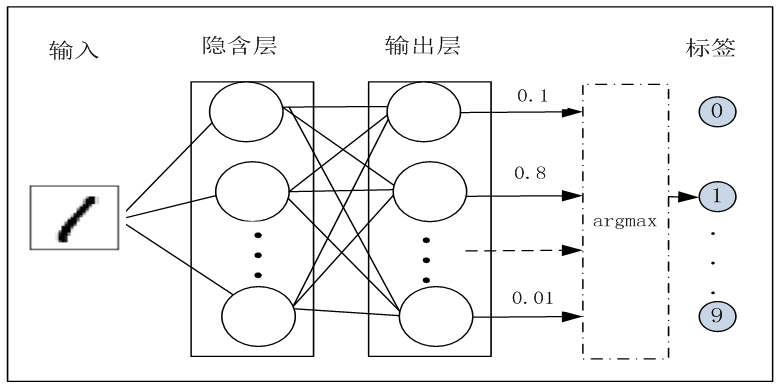
输入前将28*28矩阵转换为784向量，所以，输入层共有784个节点。输出层经softmx激活函数作用后，得到10个概率值（这些值的和为1），通过argmax函数就可知道对应的标签。

#### 13.8.4 准备数据
把解压后的4个文件，存放在当前目录的data\mnist目录下，然后利用Python程序导入内存，具体代码如下：  
（1）导入需要的库


In [1]:
import os
import struct
import numpy as np

（2）定义把分类转换为onehot编码的函数

In [2]:
def dense_to_one_hot(labels_dense, num_classes=10):
  """将类标签从标量转换为一个one-hot向量"""
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot

（3）定义加载数据函数

In [3]:
def load_mnist(path, kind='train',normal=False,onehot=False):
    """根据指定路径加载数据集"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>2I',lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        if onehot:
            labels=dense_to_one_hot(labels)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">4I",imgpath.read(16))
        if normal:
            images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)/255
        else:
            images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)            
        


    return images, labels

（4）加载数据

In [4]:
x_train, y_train = load_mnist(r'../data/mnist', kind='train',normal=True)
print('Rows: %d, columns: %d' % (x_train.shape[0], x_train.shape[1]))
#print('Rows: %d, columns: %d' % ( y_train.shape[0],  y_train.shape[1]))
print('Rows: %d' % ( y_train.shape[0]))

x_test, y_test = load_mnist(r'../data/mnist', kind='t10k',normal=True)
print('Rows: %d, columns: %d' % (x_test.shape[0], x_test.shape[1]))

Rows: 60000, columns: 784
Rows: 60000
Rows: 10000, columns: 784


（5）查看样本数据
抽取10张手写的数字图片

([], <a list of 0 Text yticklabel objects>)

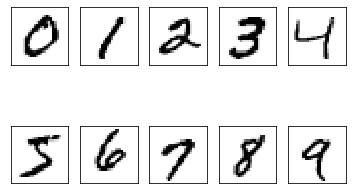

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
#0到9的数字中每个取一个
for i in range(10):
    #img = x_train[np.argmax(y_train,axis=1)==i][0].reshape(28, 28)
    img = x_train[y_train==i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
#不显示坐标轴
plt.xticks([])
plt.yticks([])

#### 13.8.5 初始化参数
对权重参数进行初始化，这里使初始化数据满足正态分布。

In [6]:
def sigmoid(x):
    s=1/(1+np.exp(-x))
    return s

In [7]:
def initialize_with_zeros(n_x,n_h,n_y,std=0.001):
    np.random.seed(2)
    W1=np.random.randn(n_h,n_x)*std    # W1=np.random.randn(n_h,n_x)
    #W1=np.random.uniform(-np.sqrt(6)/np.sqrt(n_x+n_h),np.sqrt(6)/np.sqrt(n_h+n_x),size=(n_h,n_x))    
    b1=np.zeros((n_h,1))
    W2=np.random.randn(n_y,n_h)*std  # W2=np.random.randn(n_y,n_h)
    #W2=np.random.uniform(-np.sqrt(6)/np.sqrt(n_y+n_h),np.sqrt(6)/np.sqrt(n_y+n_h),size=(n_y,n_h))
    b2=np.zeros((n_y,1))
 
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
 
    return parameters


#### 13.8.6 构建神经网络

In [8]:
def forward(X,parameters):
    W1=parameters["W1"]
    b1=parameters["b1"]
    W2=parameters["W2"]
    b2=parameters["b2"]
    # print W1,X,b1
    Z1=np.dot(W1,X)+b1
    # A1=sigmoid(Z1)
    A1=np.tanh(Z1)
    Z2=np.dot(W2,A1)+b2
    A2=sigmoid(Z2)
    
    dict = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    return A2, dict


#### 13.8.7 定义损失函数

In [9]:
def loss(A2,Y,parameters):
    #定义一个小常数，防止log中的值为0
    t=1e-6
    logprobs=np.multiply(np.log(A2+t),Y) + np.multiply(np.log(1-A2+t),(1-Y))
    loss1=np.sum(logprobs,axis=0,keepdims=True)/A2.shape[0]
    
    return loss1*(-1)


#### 13.8.8 误差反向传播

In [10]:
def backward(parameters,dict,X,Y):
    # 获取参数
    W1=parameters["W1"]
    W2=parameters["W2"]
    A1 = dict["A1"]
    A2 = dict["A2"]
    Z1=dict["Z1"]
    #误差的反向传播
    dZ2=A2-Y
 
    dW2=np.dot(dZ2,A1.T)
    db2=np.sum(dZ2,axis=1,keepdims=True)
    dZ1=np.dot(W2.T,dZ2)*(1-np.power(A1,2))
    dW1=np.dot(dZ1,X.T)
    db1=np.sum(dZ1,axis=1,keepdims=True)
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2} 

    return grads

#### 13.8.9 梯度更新

In [11]:
def gradient(parameters, grads, learning_rate ):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    #更新参数梯度
    W1=W1-learning_rate*dW1
    b1=b1-learning_rate*db1
    W2=W2-learning_rate*dW2
    b2=b2-learning_rate*db2
     
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters


#### 13.8.10 训练模型

In [12]:
if __name__ == '__main__':
    train_images = x_train
    train_labels = y_train
    test_images = x_test
    test_labels = y_test
 
    count=0
    n_x=28*28
    n_h=100
    n_y=10
    lr=0.01
    loss_all=[]
    train_size=100
    parameters=initialize_with_zeros(n_x,n_h,n_y)
    for i in range(10000):
        #每次取一个样本
        img_train=train_images[i]
        label_train1=train_labels[i]
        label_train=np.zeros((10,1))
        #批量运行
        #batch_mask = np.random.choice(train_size, batch_size)
        #x_batch = x_train[batch_mask]
        #t_batch = y_train[batch_mask]
        
        #动态修改学习率
        if i%2000==0:
            lr=lr*0.99
        #转换为onehot编码
        label_train[int(train_labels[i])]=1
        # 转换为二维向量
        imgvector=np.expand_dims(img_train,axis=1)
        
        A2,dict=forward(imgvector,parameters)
        pre_label=np.argmax(A2)
        #统计损失值
        
        loss1=loss(A2,label_train,parameters)
        grads = backward(parameters, dict, imgvector, label_train)
        parameters = gradient(parameters, grads, learning_rate = lr)
        grads["dW1"]=0
        grads["dW2"]=0
        grads["db1"]=0
        grads["db2"]=0
        #每隔循环200次打印一次
        if i%200==0:
            print("迭代：{} 次的损失值:{:.6f}".format(i,loss1[0][0]))
            loss_all.append(loss1[0][0])
            
            
    # 训练模型
    for i in range(10000):
        img_test=test_images[i]
        #vector_image=narmalize_data(image2vector(img_train))
        vector_image=np.expand_dims(img_test,axis=1)
        label_trainx=test_labels[i]
        aa2,xxx=forward(vector_image,parameters)
        predict_value=np.argmax(aa2)
        if predict_value==int(label_trainx):
            count+=1

    print("准确率:",count/10000)


迭代：0 次的损失值:0.693128
迭代：200 次的损失值:0.356405
迭代：400 次的损失值:0.258254
迭代：600 次的损失值:0.311312
迭代：800 次的损失值:0.295531
迭代：1000 次的损失值:0.253646
迭代：1200 次的损失值:0.129682
迭代：1400 次的损失值:0.164738
迭代：1600 次的损失值:0.297414
迭代：1800 次的损失值:0.250094
迭代：2000 次的损失值:0.357594
迭代：2200 次的损失值:0.183744
迭代：2400 次的损失值:0.102034
迭代：2600 次的损失值:0.174328
迭代：2800 次的损失值:0.186195
迭代：3000 次的损失值:0.302678
迭代：3200 次的损失值:0.165217
迭代：3400 次的损失值:0.036143
迭代：3600 次的损失值:0.101130
迭代：3800 次的损失值:0.024615
迭代：4000 次的损失值:0.031516
迭代：4200 次的损失值:0.051518
迭代：4400 次的损失值:0.043999
迭代：4600 次的损失值:0.309465
迭代：4800 次的损失值:0.300344
迭代：5000 次的损失值:0.056575
迭代：5200 次的损失值:0.221030
迭代：5400 次的损失值:0.113049
迭代：5600 次的损失值:0.173592
迭代：5800 次的损失值:0.284309
迭代：6000 次的损失值:0.005552
迭代：6200 次的损失值:0.076365
迭代：6400 次的损失值:0.013960
迭代：6600 次的损失值:0.229042
迭代：6800 次的损失值:0.007882
迭代：7000 次的损失值:0.071188
迭代：7200 次的损失值:0.063353
迭代：7400 次的损失值:0.070908
迭代：7600 次的损失值:0.112841
迭代：7800 次的损失值:0.015080
迭代：8000 次的损失值:0.002793
迭代：8200 次的损失值:0.815904
迭代：8400 次的损失值:0.026309
迭代：8600 次的损失值:0.23

#### 13.8.11 可视化结果

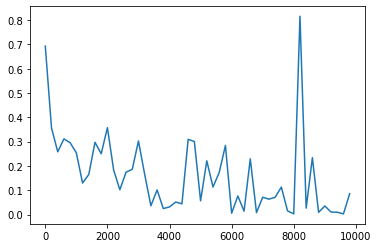

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(0,10000,200),loss_all)